In [60]:
from sklearn import preprocessing
import numpy as np
# 新版本sklearn推荐从model_selection中引入train_test_split和cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets.samples_generator import make_classification
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt

%matplotlib inline

### Preprocessing

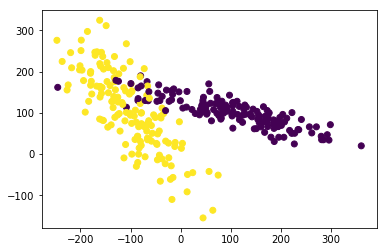

In [9]:
X, y = make_classification(
    n_samples=300,  # 样本数量
    n_features=2,  # 特征数量 = n_informative + n_redundant + n_repeated
    n_redundant=0,  # 冗余信息，informative特征的随机线性组合
    n_informative=2,  # 多信息特征的个数
    n_repeated=0,  # 重复信息，随机提取n_informative和n_redundant特征
    random_state=22, # 随机数seed，表示每次运行该代码时生成的随机数是一样的
    n_clusters_per_class=1,  # 某一个类别是由几个cluster构成的
    scale=100  # 将特征的值按scale进行缩放
)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [50]:
X = preprocessing.scale(X)

# 也可以使用minmax_scale，将样本值缩小至feature_range指定的范围
# X = preprocessing.minmax_scale(X, feature_range=(0,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
clf = SVC()
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.983333333333


### Cross Validation

In [64]:
iris = load_iris()
X = iris.data
y = iris.target

knn = KNeighborsClassifier(n_neighbors=5)

# 使用cross_val_score，cv表示将所有样本分为n组进行训练，训练结束返回
# n次训练后scoring组成的数组（这里就是accuracy数组），方便调参
score = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
print(score.mean())

0.973333333333


0.98


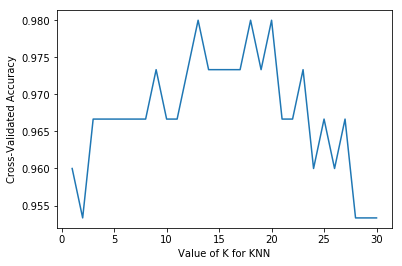

In [71]:
# KNN中K的数值，通过多次CV调试出最合适的K值
k_range = range(1, 31)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # classification使用accuracy进行评价，accuracy越高，模型越好
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy') # for classification
    # 如果使用regression，使用loss进行评价，loss越小模型越好
    # loss = -cross_val_score(knn, X, y, cv=10, scoring='mean_squared_error')
    k_scores.append(scores.mean())

print(max(k_scores))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

### Overfitting

In [73]:
from sklearn.model_selection import learning_curve
from sklearn.datasets import load_digits
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

In [86]:
digits = load_digits()
X = digits.data
y = digits.target

# 打印np.unique（唯一值），一共10类
print(np.unique(y))

(1797,)
[0 1 2 3 4 5 6 7 8 9]


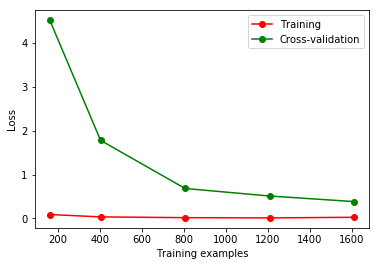

In [90]:
train_sizes, train_loss, test_loss = learning_curve(
    # SVC默认径向基函数核(kernel='rbf')，其他kernel有'linear', 'poly', 'sigmoid'等
    # gamma是选择rbf, sigmoid或poly作为kernel时，该函数自带的一个参数。
    # 该参数隐含地决定了数据映射到新的特征空间后的分布，gamma越大，支持
    # 向量越少，gamma越小，支持向量越多。支持向量的个数影响训练与预测速度。
    # 在rbf中, gamma = 1 / (2 * σ^2)。
    SVC(gamma=0.001), 
    X, y,
    cv=10,
    scoring='neg_mean_squared_error',
    # train_sizes表示训练过程，传入一个list，当训练至总训练样本的百分比
    # 至其中的元素时（例如这里分别训练至总样本0.1, 0.25, 0.5, 0.75, 1时）
    # 输出一次loss值，因此输出的train_loss和test_loss的shape为s * c, 
    # s为train_size元素个数，c为cv数
    train_sizes=[0.1, 0.25, 0.5, 0.75, 1])

train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

plt.plot(train_sizes, train_loss_mean, 'o-', color='r', label='Training')
plt.plot(train_sizes, test_loss_mean, 'o-', color='g', label='Cross-validation')

plt.xlabel('Training examples')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

In [91]:
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_digits
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

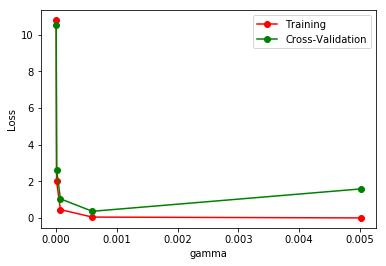

In [100]:
digits = load_digits()
X = digits.data
y = digits.target

# np.logsapce(start_power, end_power, num=50, base=10)
# 用于创建等比数列，默认底数为10，第一个参数是开始幂次，第二个参数是
# 终止幂次，num参数是等比项数，base是底数
param_range = np.logspace(-6, -2.3, 5)

# validation_curve可以接受超参数，例如这里param_name='gamma'表示
# 需要调整的超参数是SVC中的gamma参数，param_range是gamma的取值列表
train_loss, valid_loss = validation_curve(
    SVC(),
    X, y,
    param_name='gamma',
    param_range=param_range,
    cv=10,
    scoring='neg_mean_squared_error'
)

train_loss_mean = -np.mean(train_loss, axis=1)
valid_loss_mean = -np.mean(valid_loss, axis=1)

plt.plot(param_range, train_loss_mean, 'o-', color='r', label='Training')
plt.plot(param_range, valid_loss_mean, 'o-', color='g', label='Cross-Validation')

plt.xlabel('gamma')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()
# 下图中挑选cross-validation曲线拐点处（即从左往右第四个点）处对应的
# 超参数gamma的值作为模型的gamma值